In [1]:
import numpy as np
import gym
from rllr.env import minigrid_envs

In [2]:
env_conf = {
    #"env_task": "MiniGrid-LavaCrossingS9N3-v0",
    "env_task": "MiniGrid-Empty-8x8-v0",
    "grid_size": 8,
    "action_size": 3,
    "rgb_image": True,
    "norm_type": "unit_norm",
    "tile_size": 8,
    "agent_rnn_layers": 2,
    "agent_rhs_size": 128,
    "minigrid_max_steps": 64,
    "random_start_pos": True
}

In [3]:
env = minigrid_envs.gen_wrapped_env(env_conf)

In [4]:
obs = env.reset()

In [5]:
import matplotlib.pyplot as plt

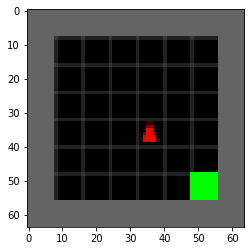

In [6]:
plt.imshow(obs)

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [8]:
def gather_data(n=2000):
    data = list()
    env = minigrid_envs.gen_wrapped_env(env_conf)
    for _ in range(n):
        obs = env.reset()
        data.append(torch.Tensor(obs))
    return data

dataset = gather_data()
dataset = TensorDataset(torch.stack(dataset, dim=0))
data = DataLoader(dataset, batch_size=128, shuffle=True)

In [9]:
from rllr.models.encoders import Permute


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        n_channels = [16, 16]
        kernel_size = [4, 3]
        strides = [4, 1]
        paddings = [0, 1]
        
        in_channels = 3
        conv_layers = [Permute(0, 3, 1, 2)]
        
        for out_cannels, k_size, stride, pad in zip(n_channels, kernel_size, strides, paddings):
            layer = nn.Conv2d(in_channels, out_cannels, k_size, stride, pad)
            conv_layers.append(layer)
            conv_layers.append(nn.LeakyReLU())
            in_channels = out_cannels
    
        self.net = nn.Sequential(*conv_layers)
    
    def get_out_shape(self, input_shape):
        x = torch.zeros(1, *input_shape)
        return self.net(x).shape[1:]
        
    def forward(self, x):
        x = self.net(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_channels):
        super(MLP, self).__init__()
        
        channels = []
        mu_layers = []
        std_layers = []
        
        for ch in channels:
            mu_layer = nn.Linear(in_channels, ch)
            mu_layers.append(mu_layer)
            mu_layers.append(nn.LeakyReLU())
            
            std_layer = nn.Linear(in_channels, ch)
            std_layers.append(std_layer)
            std_layers.append(nn.LeakyReLU())
            
            in_channels = ch
            
        self.mu_net = nn.Sequential(*(mu_layers[:-1]))
        self.std_net = nn.Sequential(*(std_layers[:-1]))
    
    def forward(self, x):
        mu = self.mu_net(x)
        log_std = self.std_net(x)
        
        x = self.reparametrize(mu, log_std)
        
        kl_loss = self.kl_loss(mu, log_std)
        return x, mu, log_std, kl_loss
    
    def reparametrize(self, mu, log_std):
        std = torch.exp(log_std / 2)
        eps = torch.randn_like(std)
        x = mu + std * eps
        return x
    
    def kl_loss(self, mu, log_std):
        kl = -0.5 * torch.mean(1 +
                               2 * log_std -
                               mu.pow(2) -
                               (2 * log_std).exp())
        return kl


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        n_channels = [16, 3]
        kernel_size = [3, 4]
        strides = [1, 4]
        paddings = [1, 0]
        
        in_channels = 16
        conv_layers = list()
        
        for out_cannels, k_size, stride, pad in zip(n_channels, kernel_size, strides, paddings):
            layer = nn.ConvTranspose2d(in_channels, out_cannels, k_size, stride, pad)
            conv_layers.append(layer)
            conv_layers.append(nn.LeakyReLU())
            in_channels = out_cannels
        
        conv_layers.pop(-1)
        conv_layers.append(nn.Sigmoid())
    
        self.net = nn.Sequential(*conv_layers)
    
    def get_out_shape(self, input_shape):
        x = torch.zeros(1, *input_shape)
        return self.net(x).shape[1:]
    
    def forward(self, x):
        x = self.net(x)
        return x

In [10]:
from nle_toolbox.zoo.vq import VQVAEEmbeddings, VQVAEIntegerCodes, VQEMAUpdater, VQLossHelper
from nle_toolbox.zoo.vq import VectorQuantizedVAE as VQ

In [11]:
num_embeddings = 32
latent_dim = 256
in_channels = 4096


class VQMLP(nn.Module):
    def __init__(self, in_channels, latent_dim, num_embeddings):
        super(VQMLP, self).__init__()
        
        start_ch = in_channels
        channels = [latent_dim]
        
        self.encode_net = nn.Linear(in_channels, latent_dim)
        self.decode_net = nn.Linear(latent_dim, in_channels)
        
        vq_layer = VQ(num_embeddings, latent_dim)
        self.vq = VQVAEEmbeddings(vq_layer)
        self.inds_net = VQVAEIntegerCodes(vq_layer)
    
    def forward(self, x):
        latent = self.encode_net(x.reshape(x.shape[0], -1))
        vq = self.vq(latent)
        return self.decode_net(vq)
    
    def encode(self, x):
        with torch.no_grad():
            latent = self.encode_net(x.reshape(x.shape[0], -1))
            vq = self.vq(latent)
        return vq
    
    def decode(self, latent):
        with torch.no_grad():
            vq = self.vq(latent)
            x = self.decode_net(vq)
        return x

    
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        self.encoder = Encoder()
        self.mid = VQMLP(in_channels, latent_dim, num_embeddings)
        self.decoder = Decoder()
    
    def forward(self, img):
        enc_img = self.encoder(img.float() / 255.)
        self.enc_img_shape = enc_img.shape
        
        latent_code = self.mid(enc_img)
        latent_code = latent_code.view(*self.enc_img_shape)
        
        restored_imgs = self.decoder(latent_code)
        return restored_imgs
    
    def encode(self, img):
        with torch.no_grad():
            latent = self.encoder(img.float() / 255.)
            vq = self.mid.encode(latent)
        return vq
    
    def decode(self, latent):
        with torch.no_grad():
            latent = self.mid.decode(latent)
            restored_img = self.decoder(latent)
        return restored_img
        

In [12]:
model = VQVAE()
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(params=model.parameters())
hlp = VQLossHelper(model, reduction='mean')
ema = VQEMAUpdater(model, alpha=0.1, update=True)

In [13]:
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
writer = SummaryWriter('temp_experiments/test_vq')

In [ ]:
from tqdm import trange


for epoch in trange(50000):
    batch_data = defaultdict(list)
    for imgs, in data:
        
        optimizer.zero_grad()
        with hlp, ema:
            restored_imgs = model(imgs)
        restore_loss = criterion(restored_imgs, imgs.float().permute(0, 3, 1, 2) / 255.)
        vq_ell = sum(hlp.finish().values())
        loss = restore_loss + vq_ell
        loss.backward()
        optimizer.step()
        ema.step()
        
        batch_data['restore_loss'].append(restore_loss.item())
        batch_data['entropy'].append(list(ema.entropy.values())[0])

    writer.add_scalar('entropy', np.mean(batch_data['entropy']), epoch)
    writer.add_scalar('restore_loss', np.mean(batch_data['restore_loss']), epoch)
    writer.add_image('initial_img', imgs[0].float() / 255., epoch, dataformats='HWC')
    writer.add_image('restored_img', restored_imgs[0], epoch, dataformats='CHW')

 55%|███████████████▎            | 27434/50000 [119:06:50<17:07:59,  2.73s/it]

In [ ]:
model.mid.decode_net[0].wrapped.weight